Reading in density field in COSMOS from Metin:

>128^3 cells
>and the dimensions of the axes are:
>
>in cMpc/h
>line of sight: 3755 to 4055
>
>and the two perpendicular axes are centered to 0, so -150 to 150 cMpc/h

In [1]:
import numpy as np
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord
import astropy.units as u

from astropy.io import fits
from astropy.io import ascii
from astropy.table import Table
import matplotlib
matplotlib.rc('mathtext',fontset='stixsans')
import matplotlib.pyplot as plt

from scipy import ndimage


In [2]:
data_dir = '/Users/kheegan/lya/cosmos_density/v0/'

den_in = np.fromfile(data_dir+'mean_cosmos_birth.dat', dtype=np.float64)

win_mos_in = np.fromfile(data_dir+'win_arr_mos.dat', dtype=np.float32)
win_vuds_in = np.fromfile(data_dir+'win_arr_vuds.dat', dtype=np.float32)
win_zc_in = np.fromfile(data_dir+'win_arr_zc.dat', dtype=np.float32)

Npix_1d = np.rint(np.cbrt(len(den_in))).astype(np.int)

#Reshape the boxes
den = den_in.reshape((Npix_1d, Npix_1d, Npix_1d))
win_mos = win_mos_in.reshape((Npix_1d, Npix_1d, Npix_1d))
win_vuds = win_vuds_in.reshape((Npix_1d, Npix_1d, Npix_1d))
win_zc = win_zc_in.reshape((Npix_1d, Npix_1d, Npix_1d))

win_all = win_mos + win_vuds + win_zc

den_sm = ndimage.gaussian_filter(den, 1., mode='wrap')

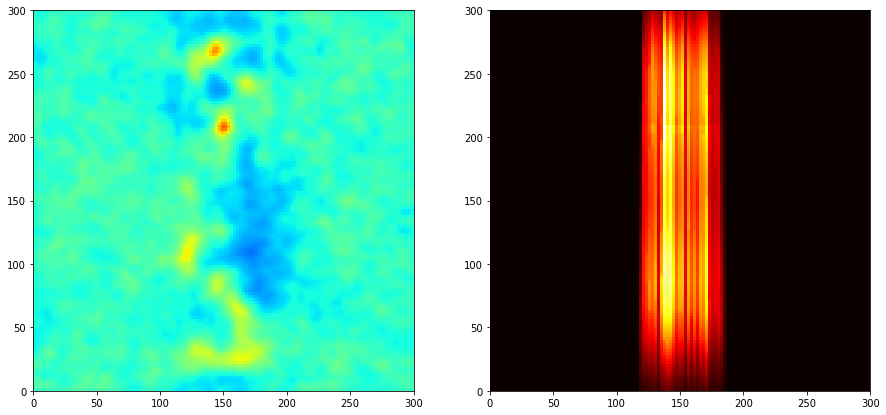

In [3]:
zcut = 69
den_slice = np.squeeze(den_sm[:,zcut,:])
win_vuds_slice = np.squeeze(win_vuds[:,zcut,:])
win_zc_slice = np.squeeze(win_zc[:,zcut,:])
win_all_slice = np.squeeze(win_all[:,zcut,:])

#zeroweight = np.where(win_all_slice == 0.)

#den_slice[zeroweight] = -2.


xbins = np.linspace(0, 300., num=128)
ybins = np.linspace(0, 300., num=128)

X, Y = np.meshgrid(xbins, ybins)

fig, (ax1, ax2)  = plt.subplots(1,2, figsize=(15, 7.3))

ax1.pcolormesh(X, Y, den_slice, cmap='jet', vmin=-0.7, vmax=1.)
ax1.set_aspect('equal')

ax2.pcolormesh(X, Y, win_all_slice, cmap='hot')
ax2.set_aspect('equal')

#ax3.pcolormesh(X, Y, win_all_slice, cmap='hot')
#ax3.set_aspect('equal')

plt.show()

---
Figure out the approximate boundaries of the data in this volume. Loop through the z-slices and figure out the boundaries in [X,Y] where the combined mask is non-zero. Then plot the min/max of both transverse axes to figure out the data boundary.

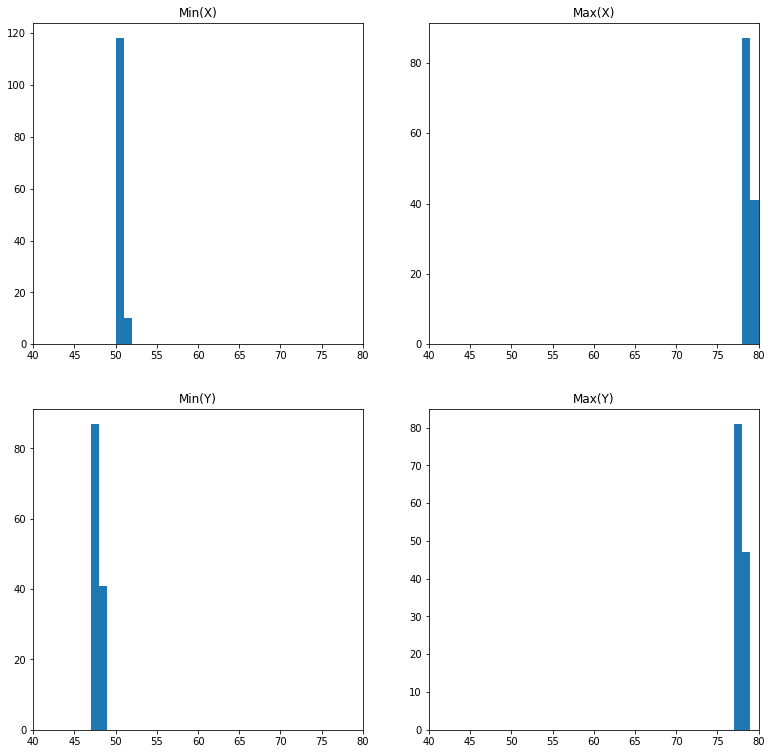

In [4]:
iy_min = np.empty(128)
iy_max = np.empty(128)
ix_min = np.empty(128)
ix_max = np.empty(128)

for kk in np.arange(0,128):
    win_all_slice = np.squeeze(win_all[kk,:,:])
    ystrip_mask = win_all_slice[:,63]
    xstrip_mask = win_all_slice[63,:]
    iy_min[kk] = np.min(np.where(ystrip_mask > 0))
    iy_max[kk] = np.max(np.where(ystrip_mask > 0))
    ix_min[kk] = np.min(np.where(xstrip_mask > 0))
    ix_max[kk] = np.max(np.where(xstrip_mask > 0))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(13, 13))


ax1.hist(ix_min, bins=np.arange(0,128))
ax1.set_title('Min(X)')
ax1.set_xlim(40, 80)
ax2.hist(ix_max, bins=np.arange(0,128))
ax2.set_title('Max(X)')
ax2.set_xlim(40, 80)
ax3.hist(iy_min, bins=np.arange(0,128))
ax3.set_title('Min(Y)')
ax3.set_xlim(40, 80)
ax4.hist(iy_max, bins=np.arange(0,128))
ax4.set_title('Max(Y)')
ax4.set_xlim(40, 80)

plt.show()


---
Implement 3D visualization with mayavi. To rotate and pan the visualization within the window, initialize mlab with 'x3d'. Note that the axes and other text doesn't show up in the x3d.

In [5]:
from mayavi import mlab
#mlab.init_notebook('png')
mlab.init_notebook('x3d')

Notebook initialized with x3d backend.


In [6]:
den_sm_clipped = den_sm[:, 48:77, 50:79]
# transpose the array so that RA appears horizontal
np.transpose(den_sm_clipped, (0,2,1))

#print(np.shape(den_sm_clipped))

z,y,x = np.mgrid[3755:4055:128j, -32.8:35.2:29j, -37.5:30.5:29j]

mlab.figure(figure=None, bgcolor=(0.,0.,0.), fgcolor=(1.,1.,1.),size=(570,350))
mlab.clf()

cont3d = mlab.contour3d(z,y,x, den_sm_clipped, contours=[0.35])


mlab.text3d(50, 62, 85, 'COSMOS Density Field', scale=2,orientation=(270,0,0), orient_to_camera=False)
#mlab.orientation_axes( xlabel='Redshift', ylabel='Dec', zlabel='RA')

# Draw outline box
mlab.outline(cont3d, color=(1,1,1), line_width=1)

# Draw axes
ax=mlab.axes(cont3d, color=(1,1,1),xlabel='z (Mpc/h)', zlabel='Dec (Mpc/h)', ylabel='R.A. (Mpc/h)', nb_labels=10)
ax.axes.label_format='%.0f'
ax.axes.font_factor=1.
ax.axes.axis_title_text_property.font_size=2

mlab.view(azimuth=215., elevation=70., distance=400., focalpoint=(3850., 12., -8.5))

cont3d



In [7]:
print(mlab.view())

(-145.00000000000003, 70.0, 399.99999999999994, array([3850. ,   12. ,   -8.5]))
